# Binary Classification with a Bank Churn Dataset
## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

SEED = 31415

## Data download and light analysis

In [2]:
train = pd.read_csv(
    '../input/playground-series-s4e1/train.csv', index_col='id')
test = pd.read_csv('../input/playground-series-s4e1/test.csv', index_col='id')
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
len(train), len(train.CustomerId.unique())

(165034, 23221)

In [4]:
train.groupby(['CustomerId']).count().sort_values(['Surname'], ascending=False)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,
15682355,121,121,121,121,121,121,121,121,121,121,121,121
15570194,99,99,99,99,99,99,99,99,99,99,99,99
15585835,98,98,98,98,98,98,98,98,98,98,98,98
15595588,91,91,91,91,91,91,91,91,91,91,91,91
15648067,90,90,90,90,90,90,90,90,90,90,90,90
...,...,...,...,...,...,...,...,...,...,...,...,...
15641625,1,1,1,1,1,1,1,1,1,1,1,1
15641624,1,1,1,1,1,1,1,1,1,1,1,1
15641621,1,1,1,1,1,1,1,1,1,1,1,1


In [5]:
train[train.CustomerId == 15682355]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
273,15682355,Hsueh,727,Germany,Male,35.0,9,140966.55,1,1.0,1.0,179227.21,0
2565,15682355,Tien,744,France,Male,37.0,6,0.00,2,1.0,1.0,137944.16,0
5063,15682355,Niu,790,Spain,Male,44.0,1,128100.75,1,1.0,0.0,164517.96,1
11942,15682355,Hsueh,616,France,Female,43.0,9,95167.82,2,0.0,1.0,132741.56,0
13009,15682355,Manna,652,Spain,Female,33.0,7,0.00,2,1.0,1.0,112333.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159573,15682355,Onwuatuegwu,679,France,Female,39.0,6,0.00,2,1.0,0.0,123977.86,0
159690,15682355,Pinto,629,Germany,Female,34.0,2,140510.34,2,1.0,0.0,143681.75,0
159923,15682355,O'Donnell,710,France,Female,35.0,7,0.00,2,1.0,1.0,147055.87,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


## Preprocess data and feature engineering

In [7]:
train['isTrain'] = 1
test['isTrain'] = 0
data = pd.concat([train.drop('Exited', axis=1), test])
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,isTrain
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,1


In [8]:
data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,isTrain
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,1
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,1
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,1
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,1
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,1


In [9]:
for column in ['Geography', 'Gender']:
    encoder = LabelEncoder()
    encoder.fit(data[column])
    data[column] = encoder.transform(data[column])

data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,isTrain
id,,,,,,,,,,,
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,1
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,1
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,1
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,1
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,1


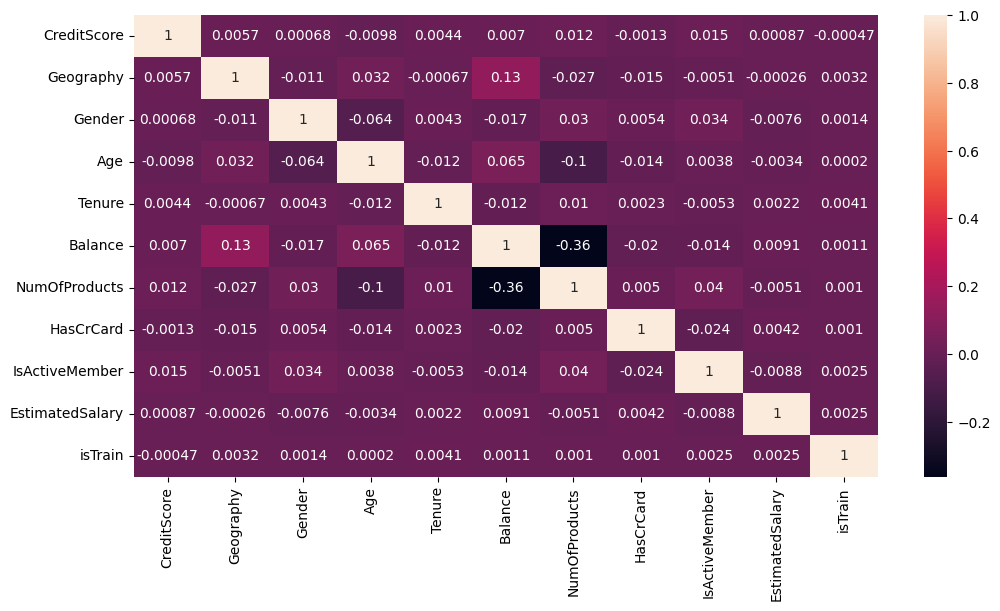

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True)
plt.show()

## Split data into samples

In [11]:
train = pd.concat([data[data.isTrain == 1].drop(
    'isTrain', axis=1), train['Exited']], axis=1)
test = data[data.isTrain == 0].drop('isTrain', axis=1)
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [12]:
train_X = train.drop('Exited', axis=1)
train_y = pd.DataFrame(train.Exited)
train_X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83


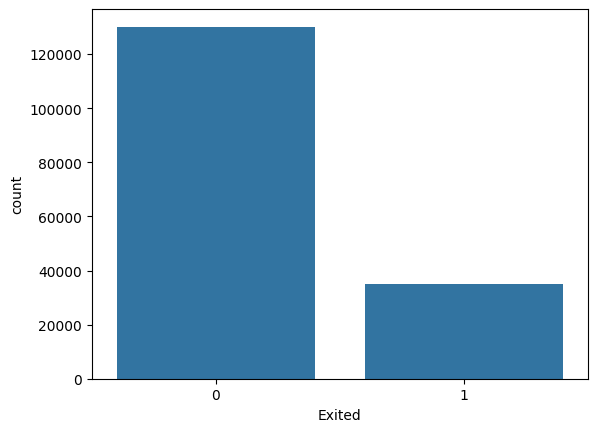

In [13]:
sns.countplot(x=train.Exited)
plt.show()

In [14]:
train_data, val_data, train_labels, val_labels = train_test_split(
    train_X, train_y, test_size=0.2, random_state=SEED)
val_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33007 entries, 102857 to 134368
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exited  33007 non-null  int64
dtypes: int64(1)
memory usage: 515.7 KB


## Prepare model

In [15]:
model = CatBoostClassifier(eval_metric='AUC', random_state=SEED)
model.fit(train_data, train_labels, silent=True)

In [16]:
val_predicted = pd.DataFrame(model.predict(
    val_data, prediction_type='Probability')[:, 1], columns=['Exited'], index=val_data.index)
val_predicted.head()

,Exited
id,
102857,0.722456
53498,0.032021
15240,0.228036
123713,0.046020
72187,0.059919


In [17]:
print('Base model ROC AUC score: ', roc_auc_score(val_labels, val_predicted))

Base model ROC AUC score:  0.8870388856594507


## Record final result

In [18]:
predict = np.array(model.predict(test, prediction_type='Probability')[:, 1])
predict

array([0.02363794, 0.83735729, 0.02303048, ..., 0.02030587, 0.15228484,
       0.2103771 ])

In [19]:
output = pd.DataFrame(columns=['id', 'Exited'])
output['id'] = test.index
output['Exited'] = predict
output.to_csv('submission.csv', index=False)
output.head()

,id,Exited
0,165034,0.023638
1,165035,0.837357
2,165036,0.023030
3,165037,0.223257
4,165038,0.392190


In [20]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      110023 non-null  int64  
 1   Exited  110023 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.7 MB
